# Analiza trga nepremičnin 

In [1]:
import pandas as pd
import os.path
import matplotlib.pyplot as plt

%matplotlib inline

nepr_file = os.path.join('podatki/obdelani_podatki', 'nepremicnine_1.csv')
nepr_z_dvojniki = pd.read_csv(nepr_file)#, index_col = 'id')

Najprej si oglejmo, kako je v sledeči analizi razdeljena Slovenija, saj je to za razumevanje ključnega pomena. Podatki so razvrščeni po (sedaj zelo aktualnih) statističnih regijah, le Osrednjeslovenska statistična regija je razdeljena na *ljubljana mesto* (označeno z rdečo) in *ljubljana okolica*. Ta delitev je, kot bomo videli, zelo smiselna saj se nepremičninska trga precej razlikujeta.

![Regije](regije.png)

Preden sem začel z delom sem opazil, da se nekateri oglasi ponovijo v več regijah. Ni nobene logike, kateri se ponovijo in kolikokrat, zato jih preprosto izpustim (takih je le okoli 50, ni škode za celoten vzorec).

In [2]:
pd.concat(g for _, g in nepr_z_dvojniki.groupby("id") if len(g) > 1)

,regija,id,ime_oglasa,vrsta_nepremicnine,tip_nepremicnine,zemljisce,velikost,cena,agencija,leto
586,dolenjska,5787946,"RAKEK, 2 KM OD IZVOZA AC UNEC",Hiša,NaN,270.0,94.0,83000.0,Zasebna ponudba,2010.0
2547,gorenjska,5787946,"RAKEK, 2 KM OD IZVOZA AC UNEC",Hiša,NaN,270.0,94.0,83000.0,Zasebna ponudba,2010.0
4518,koroska,5787946,"RAKEK, 2 KM OD IZVOZA AC UNEC",Hiša,NaN,270.0,94.0,83000.0,Zasebna ponudba,2010.0
5297,ljubljana mesto,5787946,"RAKEK, 2 KM OD IZVOZA AC UNEC",Hiša,NaN,270.0,94.0,83000.0,Zasebna ponudba,2010.0
6178,ljubljana mesto,5787946,"RAKEK, 2 KM OD IZVOZA AC UNEC",Hiša,NaN,270.0,94.0,83000.0,Zasebna ponudba,2010.0
...,...,...,...,...,...,...,...,...,...,...
15360,savinjska,5883962,"LJ. BEŽIGRAD, GLAVARJEVA ULICA",Stanovanje,NaN,NaN,42.0,NaN,D5 invest d.o.o.,1977.0
15673,savinjska,5883962,"LJ. BEŽIGRAD, GLAVARJEVA ULICA",Stanovanje,NaN,NaN,42.0,NaN,D5 invest d.o.o.,1977.0
16118,severna primorska,5883962,"LJ. BEŽIGRAD, GLAVARJEVA ULICA",Stanovanje,NaN,NaN,42.0,NaN,D5 invest d.o.o.,1977.0
16319,severna primorska,5883962,"LJ. BEŽIGRAD, GLAVARJEVA ULICA",Stanovanje,NaN,NaN,42.0,NaN,D5 invest d.o.o.,1977.0


Spodaj odstranimo dvojnike, dodamo pa dva stolpca, ki nam bosta kasneje koristila - *cena_m2*, ki predstavlja ceno na kvadratni meter in pa *desetletje*, za primerjavo starosti nepremičnin.

In [17]:
nepr_brez_dvojnikov = nepr_z_dvojniki.drop_duplicates('id')

nepr = nepr_brez_dvojnikov.set_index('id')

nepr['cena_m2'] = nepr['cena'] / nepr['velikost']

nepr['desetletje'] = (nepr['leto'] // 10) * 10

Spodaj so prikazane vse vrste nepremičnin, ki so bile oktobra na voljo. Vidimo, da prevladujejo stanovanja in hiše.

In [173]:
vrste = nepr.groupby('vrsta_nepremicnine')
vrste.size()

vrsta_nepremicnine
Garaža                121
Hiša                 5107
Posest               5071
Poslovni prostor     2095
Počitniški objekt     177
Stanovanje           3361
Vikend                518
dtype: int64

Kot vidimo, je velik del nepremičnin *posesti* - v glavnem gre tu za kmetijska zemljišča, običajno velike parcele, z relativno nizko ceno in jih je težko primerjati z ostalimi. Njihovi analizi se bomo posvetili kasneje. Pripravimo si tabelo nepremičnin, ki jih ne vključuje.

In [175]:
brez_posesti = nepr[nepr.vrsta_nepremicnine != "posest"]

## Cena na kvadratni meter po regijah

Prikazan je stolpični diagram povprečnih cen na kvadratni meter po posamezni statistični regiji. Po pričakovanjih, je povprečna cena v Ljubljani za nekajkrat višja kot drugod po Sloveniji.

<AxesSubplot:xlabel='regija'>

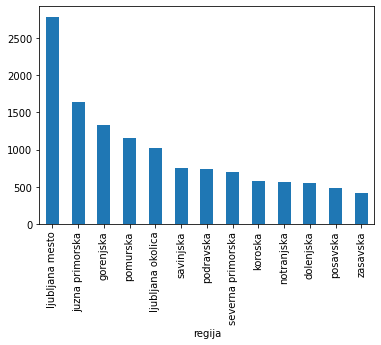

In [177]:
po_regijah = brez_posesti.groupby('regija').mean('cena_m2').sort_values('cena_m2', ascending = False)[['cena_m2']]
po_regijah.cena_m2.plot.bar()

## Vpliv starosti nepremičnine na ceno


Zanimalo nas bo, kako starost nepremičnine vpliva na njeno ceno - torej kdaj je bila zgrajena. Vidimo, da je nepremičnina v Ljubljani dražja od ostalih, ne glede na njeno starost. V skoraj vseh regijah pa so cene novejših zgradb višje (zopet je ta razlika najočitnejša v Ljubljani.)

Na spodnjem grafu je prikazano spreminjanje cene, glede na leto izgradnje po posamezni regiji.

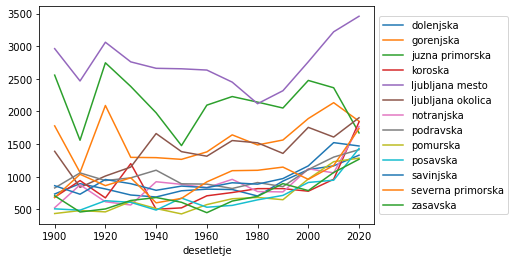

In [172]:
grupiran = brez_posesti[(brez_posesti.desetletje >= 1900) & (brez_posesti.cena_m2 <= 80000)][['regija','cena_m2','desetletje']]

gr = grupiran.groupby(['regija','desetletje'])["cena_m2"].mean().unstack(level = 0).plot()

gr.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Cene po vrsti nepremičnin

Oglejmo si, kako vrsta nepremičnine vpliva na ceno. Tu jemljemo povprečja po vseh regijah in vseh starostih. Vidimo, da je stanovanje povprečno najdražje, presenetljivo pa je nižja povprečna cena hiše. To si lahko razlagamo s tem, da je veliko hiš na prodaj v regijah izven Ljubljane, kjer je cena občutno nižja.

<AxesSubplot:xlabel='vrsta_nepremicnine'>

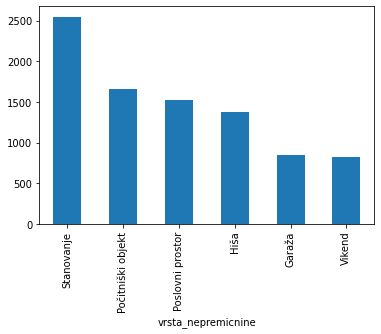

In [31]:
brez_posesti.groupby('vrsta_nepremicnine').mean('cena_m2').sort_values('cena_m2',ascending = False).cena_m2.plot.bar()

Spodaj je vsaka od zgornjih kategorij razdeljena na manjše dele. Zopet preseneča cena najmanjše stanovanjske enote - garsonjere, kar pa lahko zopet razlagamo z njihovo koncentracijo v središču Ljubljane. Visoko na lestvici so tudi pisarne.

<AxesSubplot:xlabel='tip_nepremicnine'>

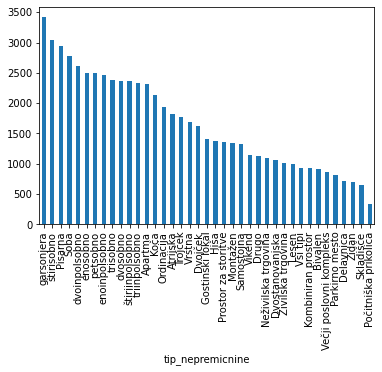

In [32]:
brez_posesti.groupby('tip_nepremicnine').mean('cena_m2').sort_values('cena_m2',ascending = False).cena_m2.plot.bar()

In [33]:
posesti = nepr[(nepr.vrsta_nepremicnine == "Posest") & (nepr.cena_m2 < 1000) ]

posesti.sort_values('cena', ascending = True).head(1500)
#posesti.groupby('regija').mean('cena').sort_values('cena', ascending = False).cena.plot.bar()

,regija,ime_oglasa,vrsta_nepremicnine,tip_nepremicnine,zemljisce,velikost,cena,agencija,leto,cena_m2,desetletje
id,,,,,,,,,,,
5796514,dolenjska,"CELJE, TEHARJE",Posest,NaN,NaN,1010.0,95.0,Borza nepremičnin d.o.o.,NaN,0.094059,NaN
6370742,ljubljana okolica,"MEDVODE, PRESKA",Posest,Zazidljiva,NaN,6225.0,100.8,Občina Medvode,NaN,0.016193,NaN
6294567,juzna primorska,"GRIŽE, SEŽANA OKOLICA - JERIŠI",Posest,Kmetijsko zemljišče,NaN,741.0,370.5,"Ruj nepremičnine, Jernej Suša, s.p.",NaN,0.500000,NaN
6193207,juzna primorska,GORNJE VREME,Posest,Kmetijsko zemljišče,NaN,1190.0,600.0,"Ruj Nepremičnine, Jernej Suša, s.p.",NaN,0.504202,NaN
6276142,ljubljana okolica,GROSUPLJE,Posest,Drugo,NaN,5.0,750.0,Zasebna ponudba,NaN,150.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6209585,savinjska,SPODNJE NEGONJE,Posest,Zazidljiva,NaN,919.0,35000.0,"Agenti nepremičninsko posredovanje, d.o.o.",NaN,38.084875,NaN
6205014,gorenjska,PLANINA POD GOLICO,Posest,Zazidljiva,NaN,779.0,35000.0,"Aeon nepremičnine, d.o.o.",NaN,44.929397,NaN
6336600,savinjska,NOVA CERKEV,Posest,Zazidljiva,NaN,700.0,35000.0,Blok d.o.o.,NaN,50.000000,NaN


## Vpliv velikosti na ceno

Podrobneje si oglejmo še, kako velikost (zaokrožena na 100 kvadratnih metrov) vpliva na ceno na kvadratni meter. Kot smo videli zgoraj so garsonjere povprečno najdražje, kar se precej jasno odraža tudi na spodnjem grafu. Pri večjih nepremičninah jasnih trendov ni - verjetno tudi zaradi relativno manjšega vzorca.

c:\users\mitja\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


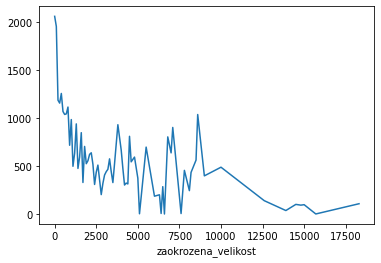

In [34]:
brez_posesti['zaokrozena_velikost'] = brez_posesti['velikost'] // 100 * 100

velikosti = brez_posesti[brez_posesti.zaokrozena_velikost < 20000].groupby('zaokrozena_velikost').mean('cena_m2').cena_m2.plot()